In [1]:
!pip install pandas scikit-learn tensorflow seaborn matplotlib


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

df = pd.read_csv("/kaggle/input/hawktuah/reviews_data_with_sentiment.csv")
df

2025-04-30 06:29:47.401167: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745994587.688017      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745994587.762298      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs

,name,location,Date,Rating,Review,Image_Links,sentiment
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...,['No Images'],positive
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...,['No Images'],positive
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...,['https://media.consumeraffairs.com/files/cach...,positive
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...,['No Images'],positive
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...,['https://media.consumeraffairs.com/files/cach...,positive
...,...,...,...,...,...,...,...
845,Becky,"Agoura Hills, CA","Reviewed July 13, 2006",NaN,I ordered two venti frappacino's without whipp...,['No Images'],NaN
846,Bob,"Goodrich, MI","Reviewed Jan. 3, 2005",NaN,No Review Text,['No Images'],NaN
847,Erik,"Valley Village, CA","Reviewed Nov. 5, 2004",NaN,"DEMANDED TIPS FROM ME, THEN MADE ME WAIT UNTIL...",['No Images'],NaN
848,Andrew,"Fallbrook, CA","Reviewed Oct. 20, 2004",NaN,No Review Text,['No Images'],NaN


In [20]:
label_enc = LabelEncoder()
df['sentiment_encoded'] = label_enc.fit_transform(df['sentiment'])
print(df['sentiment'].value_counts(dropna=False))
df = df[df['sentiment'].isin(['negative','neutral','positive'])]

df


sentiment
negative    550
positive    122
neutral      33
Name: count, dtype: int64


/tmp/ipykernel_31/376470470.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment_encoded'] = label_enc.fit_transform(df['sentiment'])


,name,location,Date,Rating,Review,Image_Links,sentiment,sentiment_encoded,tokens
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...,['No Images'],positive,2,"[amber, and, ladonna, at, the, starbucks, on, ..."
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...,['No Images'],positive,2,"[*, *, at, the, starbucks, by, the, fire, stat..."
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...,['https://media.consumeraffairs.com/files/cach...,positive,2,"[i, just, wanted, to, go, out, of, my, way, to..."
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...,['No Images'],positive,2,"[me, and, my, friend, were, at, starbucks, and..."
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...,['https://media.consumeraffairs.com/files/cach...,positive,2,"[i, ’, m, on, this, kick, of, drinking, 5, cup..."
...,...,...,...,...,...,...,...,...,...
700,Margaret,"Cotati, CA","Reviewed Oct. 2, 2011",1.0,I ordered Via Starbucks coffee online. I recei...,['No Images'],negative,0,"[i, ordered, via, starbucks, coffee, online, ...."
701,Ric,"Oakville, ON","Reviewed Aug. 31, 2011",3.0,"My name is Ric **, I am journalist by professi...",['No Images'],neutral,1,"[my, name, is, ric, *, *, ,, i, am, journalist..."
702,Jayne,"Ny, NY","Reviewed Aug. 24, 2011",1.0,"The bagel was ice cold, not cut and not toasted.",['No Images'],negative,0,"[the, bagel, was, ice, cold, ,, not, cut, and,..."
703,Norma,"La Puente, CA","Reviewed Aug. 15, 2011",1.0,"In the morning of Monday, August 15, 2011, at ...",['No Images'],negative,0,"[in, the, morning, of, monday, ,, august, 15, ..."


In [21]:
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()
df['sentiment_encoded'] = label_enc.fit_transform(df['sentiment'])
print(label_enc.classes_)           # should be ['negative','neutral','positive']
print(df['sentiment_encoded'].unique())  # should be [0,1,2]


['negative' 'neutral' 'positive']
[2 0 1]


In [22]:

# Tokenize reviews
df['tokens'] = df['Review'].apply(lambda x: word_tokenize(str(x).lower()))

In [23]:
# Train Word2Vec (CBOW)
w2v_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=1, sg=0)

# Create embedding matrix
vocab = w2v_model.wv.key_to_index
embedding_dim = w2v_model.vector_size

In [24]:
# Map words to vectors
def tokens_to_vectors(tokens):
    return [w2v_model.wv[word] for word in tokens if word in vocab]

# after training w2v_model and df['tokens']…

max_len = 100
embedding_dim = w2v_model.vector_size
sequences = df['tokens'].apply(tokens_to_vectors)  # List[List[np.array(shape=(100,))]]

# Initialize zero array
X = np.zeros((len(sequences), max_len, embedding_dim), dtype='float32')

# Fill in word vectors
for i, vecs in enumerate(sequences):
    length = min(len(vecs), max_len)
    for t in range(length):
        X[i, t, :] = vecs[t]    # each vecs[t] is a 1D array of size embedding_dim

y = df['sentiment_encoded'].values

# Now X.shape == (n_samples, max_len, embedding_dim)
print("X shape:", X.shape)  # should be (num_reviews, 100, 100)


X shape: (705, 100, 100)


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Build model function
def build_model(cell_type='RNN'):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(max_len, embedding_dim)))

    if cell_type == 'RNN':
        model.add(tf.keras.layers.SimpleRNN(64))
    elif cell_type == 'LSTM':
        model.add(tf.keras.layers.LSTM(64))
    elif cell_type == 'GRU':
        model.add(tf.keras.layers.GRU(64))

    model.add(tf.keras.layers.Dense(3, activation='softmax'))  # 3 sentiment classes
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train and evaluate models
results = {}

In [27]:
print(X_train.shape, X_train.dtype)   # should be (n, max_len, emb_dim), float32
print(y_train.shape, y_train.dtype)   # should be (n,), int32 or int64


(564, 100, 100) float32
(564,) int64


In [28]:
# 1. Get a small batch
x_batch = X_train[:32]
y_batch = y_train[:32]

# 2. Forward pass to get logits
logits = model.predict(x_batch)
print("Logits shape:", logits.shape)            # should be (32, 3) :contentReference[oaicite:7]{index=7}

# 3. Inspect labels
print("Labels shape:", y_batch.shape)           # should be (32,)
print("Unique labels:", np.unique(y_batch))     # should only be [0,1,2] :contentReference[oaicite:8]{index=8}

# 4. Manual loss computation
from tensorflow.keras.losses import SparseCategoricalCrossentropy
loss_fn = SparseCategoricalCrossentropy()
print("Batch loss:", loss_fn(y_batch, logits).numpy())  # isolate any error here :contentReference[oaicite:9]{index=9}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Logits shape: (32, 3)
Labels shape: (32,)
Unique labels: [0 1 2]
Batch loss: 1.1634543


In [35]:

for model_type in ['RNN', 'LSTM', 'GRU']:
    print(f"\nTraining {model_type}...")
    model = build_model(model_type)
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    acc = accuracy_score(y_test, y_pred_classes)
    prec = precision_score(y_test, y_pred_classes, average='weighted')
    rec = recall_score(y_test, y_pred_classes, average='weighted')
    f1 = f1_score(y_test, y_pred_classes, average='weighted')

    results[model_type] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-score': f1}



Training RNN...
Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6523 - loss: 0.8657
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7943 - loss: 0.6377
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7976 - loss: 0.5618
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8164 - loss: 0.5408
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8046 - loss: 0.5368
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7861 - loss: 0.5638
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7943 - loss: 0.5542
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8194 - loss: 0.5289
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7689 - loss: 0.5913
Epoch 10/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7813 - loss: 0.5859
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step

Training LSTM...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.7527 - loss: 0.7749
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8129 - loss: 0.5347
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7860 - loss: 0.5669
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8035 - loss: 0.5799
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7864 - loss: 0.5858
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7999 - loss: 0.5420
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8157 - loss: 0.5314
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7967 - loss: 0.5521
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8206 - loss: 0.4910
Epoch 10/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8337 - loss: 0.4941
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step

Training GRU...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.7780 - loss: 0.7882
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.7889 - loss: 0.7151
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.7745 - loss: 0.6367
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.7990 - loss: 0.5627
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.7972 - loss: 0.5687
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.7892 - loss: 0.5449
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.7884 - loss: 0.5787
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.7938 - loss: 0.5564
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.7763 - loss: 0.5662
Epoch 10/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.7931 - loss: 0.5185
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


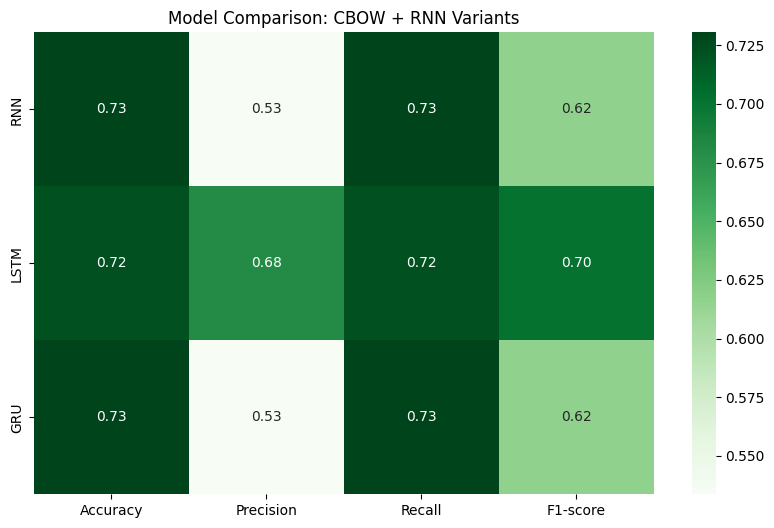

In [36]:
# Visualize results
results_df = pd.DataFrame(results).T
plt.figure(figsize=(10, 6))
sns.heatmap(results_df, annot=True, cmap='Greens', fmt=".2f")
plt.title("Model Comparison: CBOW + RNN Variants")
plt.show()

In [33]:
example_review = "This StarBucks has good humor but bad service lol!"

tokens = word_tokenize(example_review.lower())
vecs = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv.key_to_index]


# --- 2. Pad to max_len x emb_dim ---
max_len = 100
emb_dim  = w2v_model.vector_size
X_input  = np.zeros((1, max_len, emb_dim), dtype='float32')
for t, vec in enumerate(vecs[:max_len]):
    X_input[0, t, :] = vec

# --- 3. Load or rebuild each model type ---
models = {
    'RNN': build_model('RNN'),
    'LSTM': build_model('LSTM'),
    'GRU': build_model('GRU'),
}

# --- 4. Predict and decode ---
for name, model in models.items():
    probs   = model.predict(X_input)           # shape (1,3)
    class_i = np.argmax(probs, axis=1)[0]      # 0,1,2
    label   = label_enc.inverse_transform([class_i])[0]
    print(f"{name} predicts: {label} (conf={probs[0,class_i]:.2f})")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
RNN predicts: neutral (conf=0.35)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
LSTM predicts: neutral (conf=0.33)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
GRU predicts: negative (conf=0.33)


In [38]:
example_review = "This StarBucks had good drinks and the machines were working for once."

tokens = word_tokenize(example_review.lower())
vecs = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv.key_to_index]


# --- 2. Pad to max_len x emb_dim ---
max_len = 100
emb_dim  = w2v_model.vector_size
X_input  = np.zeros((1, max_len, emb_dim), dtype='float32')
for t, vec in enumerate(vecs[:max_len]):
    X_input[0, t, :] = vec

# --- 3. Load or rebuild each model type ---
models = {
    'RNN': build_model('RNN'),
    'LSTM': build_model('LSTM'),
    'GRU': build_model('GRU'),
}

# --- 4. Predict and decode ---
for name, model in models.items():
    probs   = model.predict(X_input)           # shape (1,3)
    class_i = np.argmax(probs, axis=1)[0]      # 0,1,2
    label   = label_enc.inverse_transform([class_i])[0]
    print(f"{name} predicts: {label} (conf={probs[0,class_i]:.2f})")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
RNN predicts: neutral (conf=0.39)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
LSTM predicts: neutral (conf=0.33)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
GRU predicts: negative (conf=0.33)


In [41]:
example_review = "Bad Starbucks service but atleast the waitress was good."

tokens = word_tokenize(example_review.lower())
vecs = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv.key_to_index]


# --- 2. Pad to max_len x emb_dim ---
max_len = 100
emb_dim  = w2v_model.vector_size
X_input  = np.zeros((1, max_len, emb_dim), dtype='float32')
for t, vec in enumerate(vecs[:max_len]):
    X_input[0, t, :] = vec

# --- 3. Load or rebuild each model type ---
models = {
    'RNN': build_model('RNN'),
    'LSTM': build_model('LSTM'),
    'GRU': build_model('GRU'),
}

# --- 4. Predict and decode ---
for name, model in models.items():
    probs   = model.predict(X_input)           # shape (1,3)
    class_i = np.argmax(probs, axis=1)[0]      # 0,1,2
    label   = label_enc.inverse_transform([class_i])[0]
    print(f"{name} predicts: {label} (conf={probs[0,class_i]:.2f})")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
RNN predicts: negative (conf=0.38)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
LSTM predicts: negative (conf=0.33)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
GRU predicts: negative (conf=0.33)


In [45]:
# 1. Choose the metric you care about
metric = 'F1-score'

# 2. Find the model with the highest value for that metric
best_model = max(results, key=lambda m: results[m][metric])
best_score = results[best_model][metric]

# 3. Print out the winner
print(f"Based on {metric}, the best model is {best_model} with a score of {best_score:.4f}.")

# 4. (Optional) Print a full ranking
ranked = sorted(results.items(), key=lambda item: item[1][metric], reverse=True)
print("\nFull ranking by F1-score:")
for rank, (model_name, scores) in enumerate(ranked, start=1):
    print(f" {rank}. {model_name:<4} → {metric}: {scores[metric]:.4f}")


Based on F1-score, the best model is LSTM with a score of 0.7014.

Full ranking by F1-score:
 1. LSTM → F1-score: 0.7014
 2. RNN  → F1-score: 0.6167
 3. GRU  → F1-score: 0.6167
